This is the course outlined in: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


Another nice course: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

# 1. Data preparation

In [97]:
import pandas as pd
from datetime import datetime

fname = './data/time_series_course_data/pollution.txt'
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
data = pd.read_csv(fname,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
data.drop('No', axis=1, inplace=True)
# manually specify column names
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]


In [22]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Make some plots


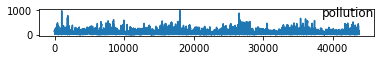

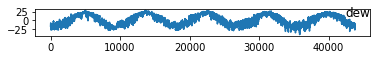

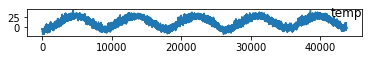

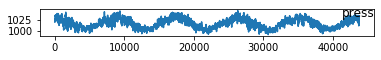

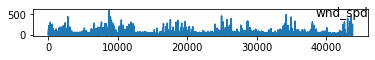

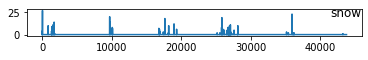

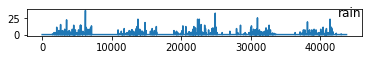

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
    plt.show()

# 2. Multivariate LSTM Forecast Model
The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:

- Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
- Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.


Some data preparation


This data preparation is simple and there is more we could explore. Some ideas you could look at include:

- One-hot encoding wind direction.
- Making all series stationary with differencing and seasonal adjustment.
- Providing more than 1 hour of input time steps.
- This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

In [121]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#     print(names)
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = data.values
# integer encode wind direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
# frame as supervised learning
window_size = 3
reframed = series_to_supervised(scaled, window_size, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[-7:], axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

(43800, 8)
   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var8(t-2)  var1(t-1)  \
3   0.000000        0.0   0.148893   0.367647  ...        0.0   0.159960   
4   0.000000        0.0   0.159960   0.426471  ...        0.0   0.182093   
5   0.000000        0.0   0.182093   0.485294  ...        0.0   0.138833   
6   0.037037        0.0   0.138833   0.485294  ...        0.0   0.109658   
7   0.074074        0.0   0.109658   0.485294  ...        0.0   0.105634   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
3   0.426471   0.229508   0.545454

## Define and Fit Model
In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [126]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
n_features = scaled.shape[1] #number of features
train_X = train_X.reshape((train_X.shape[0], window_size, n_features))
test_X = test_X.reshape((test_X.shape[0], window_size, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [26]:
(train_X.shape[1], train_X.shape[2])

(1, 8)

Train on 8760 samples, validate on 35037 samples
Epoch 1/10
 - 2s - loss: 0.0047 - val_loss: 0.0020
Epoch 2/10
 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 3/10
 - 1s - loss: 0.0011 - val_loss: 0.0016
Epoch 4/10
 - 1s - loss: 0.0011 - val_loss: 0.0017
Epoch 5/10
 - 1s - loss: 9.8055e-04 - val_loss: 0.0016
Epoch 6/10
 - 1s - loss: 9.5685e-04 - val_loss: 0.0015
Epoch 7/10
 - 1s - loss: 9.5511e-04 - val_loss: 0.0015
Epoch 8/10
 - 1s - loss: 9.5036e-04 - val_loss: 0.0014
Epoch 9/10
 - 1s - loss: 9.3885e-04 - val_loss: 0.0014
Epoch 10/10
 - 1s - loss: 9.3886e-04 - val_loss: 0.0014


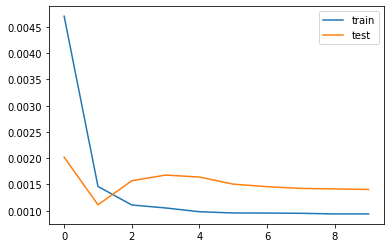

In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

# design network
model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
model.add(Dense(400, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Running the example first creates a plot showing the train and test loss during training.

Interestingly, we can see that test loss drops below training loss. The model may be overfitting the training data. Measuring and plotting RMSE during training may shed more light on this.

## Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [128]:
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_reshaped[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 37.256


RMSE with LSTM was 27

# Evaluate MLP model

In [141]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

def run_model(experiment_label, window_size=1):
    fname = './data/time_series_course_data/pollution.txt'
    # load data
    def parse(x):
        return datetime.strptime(x, '%Y %m %d %H')
    data = pd.read_csv(fname,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
    data.drop('No', axis=1, inplace=True)
    # manually specify column names
    data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
    data.index.name = 'date'
    # mark all NA values with 0
    data['pollution'].fillna(0, inplace=True)
    # drop the first 24 hours
    data = data[24:]


    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    #     print(names)
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    values = data.values
    # integer encode wind direction
    encoder = LabelEncoder()
    values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, window_size, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[-7:], axis=1, inplace=True)
    print(reframed.head())
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = 365 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    n_features = scaled.shape[1] #number of features
    train_X = train_X.reshape((train_X.shape[0], window_size, n_features))
    test_X = test_X.reshape((test_X.shape[0], window_size, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    # design network
    model = Sequential()
#     model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss='mae', optimizer='adam')
    model.add(Dense(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=48, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title(f'Experiment {experiment_label}')
    plt.legend()
    plt.show()
    
    # make a prediction
    yhat = model.predict(test_X)
    n_features = scaled.shape[1]
    test_X_reshaped = test_X.reshape((test_X.shape[0], window_size*n_features))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X_reshaped[:, -7:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X_reshaped[:, -7:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    return model, scaler, scaled, train_X, test_X, train_y, test_y, inv_y, inv_yhat

   var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
6   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
7   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
8   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
9   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-5)  var8(t-5)  var1(t-4)  var2(t-4)  ...  var8(t-2)  var1(t-1)  \
5   0.000000        0.0   0.148893   0.367647  ...        0.0   0.138833   
6   0.000000        0.0   0.159960   0.426471  ...        0.0   0.109658   
7   0.000000        0.0   0.182093   0.485294  ...        0.0   0.105634   
8   0.037037        0.0   0.138833   0.485294  ...        0.0   0.124748   
9   0.074074        0.0   0.109658   0.485294  ...        0.0   0.120724   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
5   0.485294   0.229508   0.563637   0.666667

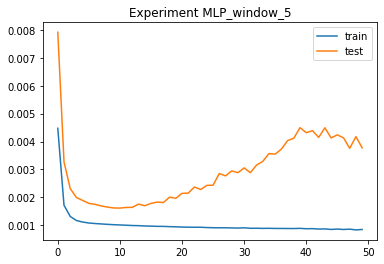

Test RMSE: 61.049


In [143]:
window_size = 5
model, scaler, scaled, train_X, test_X, train_y, test_y, inv_y, inv_yhat = run_model('MLP_window_5', window_size)

      y     y_pred
0  17.0  39.588467
1  14.0  26.119310
2  14.0  32.954998
3  22.0  38.458488
4  22.0  29.408743


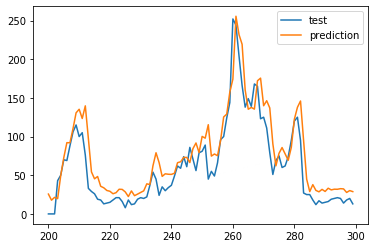

In [150]:
data = pd.DataFrame({'y': inv_y, 'y_pred': inv_yhat})
print(data.head())
ii = 200
jj = 300
plt.plot(data.index.values[ii:jj], data['y'].values[ii:jj], label='test')
plt.plot(data.index.values[ii:jj], data['y_pred'].values[ii:jj], label='prediction')
plt.legend()
plt.show()

In [92]:
# evaluate
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

ValueError: operands could not be broadcast together with shapes (35035,40) (8,) (35035,40) 